In [1]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import pickle
import os
import sys
from osgeo import ogr
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import shapely
from scipy.optimize import minimize
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon,shape
from shapely.strtree import STRtree  
import glob
import time
import shutil


sys.path.insert(1, '../../modules')
# hand made functions
from Rouss1 import *
from Rouss2 import *
from Rouss3D import *
from ZoneBudget_ludo import *

sys.path.insert(1,"../../Model_val/upscalling/")
from upscalling_functions import*

flopy is installed in C:\Users\emmal\Anaconda3\lib\site-packages\flopy


In [2]:
model_dir = "working"
model_name = "test_3D"
exe_name= "../../exe/mf6"

In [3]:
R_path="../../data/shp/limiteModeleRoussillon_poly.shp" # path to the shp of the aquifer

#rivers paths
Agly_path = "../../data/Fleuves/Agly_ludo.shp" # path to Agly
Tet_path = "../../data/Fleuves/Tet_ludo.shp"
Rea_path = "../../data/Fleuves/Reart_ludo.shp"
Tech_path = "../../data/Fleuves/Tech_ludo.shp"
Bol_path = "../../data/Fleuves/Boules_ludo.shp"
Cant_path = "../../data/Fleuves/Cant_ludo.shp"

#stations paths
Agly_stations = "../../data/Fleuves/stations_agly.csv" 
Tet_stations = "../../data/Fleuves/stations_tet2.csv"
Rea_stations = "../../data/Fleuves/stations_reart.csv"
Tech_stations = "../../data/Fleuves/stations_tech.csv"
Bol_stations = "../../data/Fleuves/stations_bol.csv"
Cant_stations = "../../data/Fleuves/stations_cant.csv"

In [4]:
# load dis infos
top,botm,idomain = read_pickle(os.path.join(model_dir,"export_dis3D"))

In [5]:
#spatial parameters

MNT_path = "../../data/surfaces_geoter/TOPO  (0 en mer).ASC"
x0,y0,x1,y1 = get_MNTbbox(MNT_path)

nlay = idomain.shape[0]
ncol = idomain.shape[2]
nrow = idomain.shape[1]
res = 300

delr = np.ones(ncol)*res
delc = np.ones(nrow)*res

grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0) # create a grid identical to the dis package, will be used
                                                                   # to pre-process data

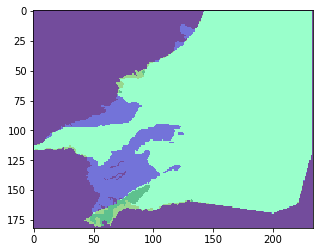

In [6]:
# a little plot
#idomain[idomain==0]=None
plt.imshow(idomain[1],alpha=0.4,cmap="bone")
plt.imshow(idomain[2],alpha=0.4,cmap="hot")
plt.imshow(idomain[0],alpha=0.4,cmap="winter")

In [7]:
# Do a list of all active cells
lst_domain = []
for ilay in range(nlay):
    for irow in range(nrow):
        for icol in range(ncol):
            if idomain[ilay,irow,icol] == 1:
                lst_domain.append((ilay,irow,icol))


In [8]:
#uppermost active cell
Up_cells_act = up_act_cell(idomain)

In [9]:
# BC sea
# import the shapefile that correspond to the BC
BCsea_path = "../../data/shp/sea_bc_extended.shp"
BC_sea = gp.read_file(BCsea_path)

# extract cellids from the BC at the sea and make these cells active
lst_chd = gp2cellids3D(grid,BC_sea,idomain,type="polygon",idomain_active=True)

# attribute a constant head at all the cells in the lst_chd
chd_lst=[];
for x in lst_chd:
    chd_lst.append((x,-0.025*top[x[1],x[2]]))
    #chd_lst.append((x,0.1))

In [10]:
# BC etangs
BCetangs_path = "../../data/shp/Surface_hydro/SURFACE_HYDROGRAPHIQUE.shp"
Bcet = gp.read_file(BCetangs_path)
etangs = Bcet[(Bcet["TOPONYME"]=="étang de canet") | (Bcet["TOPONYME"]=="étang de leucate")]

# extract cellids from the BC 
etangs_chd = gp2cellids3D(grid,etangs.dissolve(by="NATURE"),idomain,idomain_active=True)

# attribute a constant head
elev = 0.1; et_drn_lst=[];
for x in etangs_chd:
    et_drn_lst.append((x,elev,1))

In [11]:
Agy_chd = Complete_riv(Agly_path,Agly_stations,28,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Tech_chd = Complete_riv(Tech_path,Tech_stations,180,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Cant_chd = Complete_riv(Cant_path,Cant_stations,140,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Rea_chd = Complete_riv(Rea_path,Rea_stations,100,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Tet_chd = Complete_riv(Tet_path,Tet_stations,180,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Bol_chd = Complete_riv(Bol_path,Bol_stations,180,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)

lst_riv_chd=[Agy_chd,Tech_chd,Cant_chd,Rea_chd,Tet_chd,Bol_chd]
cond = [0.01,0.01,0.01,0.01,0.01,0.01]

for iriv in range(len(lst_riv_chd)):
    chd2riv(lst_riv_chd[iriv],cond[iriv],2)

C:\Users\emmal\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [12]:
def importWells3D(path,grid,lst_domain,fac=1/365/86400,V_col="V Bancaris",geol_col="NAPPE_CAPT",
                  geol_layer=["PLIOCENE","QUATERNAIRE"],layer_num=[1,0]):
    
    """
    extract the infos about the amount of water uptake by wells
    path : path to the shp (multi points required)
    grid : the modelgrid
    fac : the factor to transform volume units to get m3/s (depends of original units)
    V_col : the column name containing info about Volume
    geol_col = the column name containing geol infos
    geol_layer : the name of the differents lithology encountered 
    layer_num : the num layer corresponding to the lithology in geol_layer
    note : multiple layer can be assigned to one lithology (assign multiple number in layer_num),
    in that case the uptake will be equally separate through each specified layer
    """
    
    ix=GridIntersect(grid)
    BD_prlvm = gp.read_file(path)
    stress_data_well=[]
    
    for ilayer in range(len(geol_layer)): # iterate through layers
        BD = BD_prlvm[BD_prlvm[geol_col] == geol_layer[ilayer]] # only keep layers with the right geol
        for o in BD.index: #iterate through each well
            Vw = BD.loc[o,V_col]
            if not (np.isnan(Vw)) | (Vw == 0): #keep productive well
                    cellidx = ix.intersect_point(BD.geometry[o]).cellids[0][0]
                    cellidy = ix.intersect_point(BD.geometry[o]).cellids[0][1]
                    
                    if type(layer_num[ilayer]) == int :
                        cellid = (layer_num[ilayer],cellidx,cellidy) #cell on which the well is active
                        if cellid in lst_domain: # check if the well is in the domain
                            stress_data_well.append((cellid,-fac*Vw))
                    elif len(layer_num[ilayer]) > 1:
                        cpt=0
                        for isublay in layer_num[ilayer]:
                            cellid = (isublay,cellidx,cellidy)
                            if cellid in lst_domain:
                                cpt+=1
                        for isublay in layer_num[ilayer]:   
                            cellid = (isublay,cellidx,cellidy)
                            if cellid in lst_domain: # check if the well is in the domain
                                stress_data_well.append((cellid,-fac*Vw/cpt))
    
    return stress_data_well,cpt

In [13]:
# extraction
path = "../../data/prélèvements/BD_FORAGES_SMNPR/SMNPRV2.shp"

stress_data_well,cpt = importWells3D(path,grid,lst_domain,fac=1/365/86400,V_col="V_A_AEMRC", geol_col="NAPPE_CAPT",
                                 geol_layer=["PLIOCENE","QUATERNAIRE"],layer_num=[[2,3],0])

In [14]:
#permea
k = np.array([7.62e-04,0.25e-8,2.3e-05,2.8e-05])

In [15]:
# control piezos
piez_path="../../data/piezos/pz_hydriad.xlsx"

#import the data using ImportControlPz3D (path,modelgrid, sheetname of the data,piezometric level column, x and y coor (in L93 !))
geol_layer = ["Quaternaire","Pliocène"]
geol_col = "AquifèreCapté"
Control_Pz = ImportControlPz3D(piez_path,sheet_name="2012",geol_layer=geol_layer,layer_num=[0,2],geol_col=geol_col,
                               grid=grid,nlay=nlay,np_col = "NP_Avril2013")

C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [16]:
#recharge
rch_path = "../../data/recharge/rast_peff2.tif"
rcha = import_rch(rch_path,grid)

rch_lst=[]
for icell in Up_cells_act:
    irow = icell[1]
    icol = icell[2]
    rch_lst.append(((icell),rcha[irow,icol]/1000/365/86400))

In [17]:
## Thuir
BDcells = cellidBD(idomain,layer=2)

ix = GridIntersect(grid)
poly = Polygon([(674e3,616.8e4),(674e3,617.4e4),(678e3,617.4e4),(678e3,616.8e4)])
layer = 2
plio_chd = []
for cellid in ix.intersect_polygon(poly).cellids:
    cell = (layer,cellid[0],cellid[1])
    if cell in BDcells:
        plio_chd.append((cell,120))

In [18]:
# Corbières
layer = 2
BDcells = cellidBD(idomain,layer)
poly = Polygon([(685e3,618.7e4),(685e3,619.5e4),(696e3,619.5e4),(696e3,618.7e4)])

Corb_spd = []
Corb_lst = []
flux = 0.2
res = ix.intersect_polygon(poly)
for cellid in res.cellids:
    cell = (layer,cellid[0],cellid[1])
    if cell in BDcells:
        Corb_lst.append(cell)
n_cells = len(Corb_lst)

for cell in Corb_lst:
    Corb_spd.append((cell,flux/n_cells))

In [372]:
# basic modules
sim = fp.mf6.MFSimulation(sim_name='first3D_mf6', version='mf6', exe_name=exe_name, 
                         sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,xorigin=x0,yorigin=y0,idomain=idomain)

tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])
ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity="simple")

# initial conditions
ic   = fp.mf6.ModflowGwfic(gwf,strt=botm+1)

# output control
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            saverecord=[('HEAD', 'LAST'),
                                        ('BUDGET', 'LAST')],
                            printrecord=[('BUDGET', 'ALL')])

# nodeflowproperty
npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=k,save_flows=True)

#well
wel = fp.mf6.ModflowGwfwel(gwf,pname="wel",maxbound=len(stress_data_well),
                           stress_period_data=stress_data_well,save_flows=True)

# recharge
rch = fp.mf6.ModflowGwfrch(gwf,pname = "rch",maxbound=len(rch_lst),stress_period_data=rch_lst,save_flows=True)

#Corbières
Corb = fp.mf6.ModflowGwfwel(gwf,pname="Corb",filename="Corb.wel",maxbound=len(Corb_spd),
                            stress_period_data=Corb_spd,save_flows=True)

#constant heads
chd = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='sea', filename="sea.chd", maxbound=len(chd_lst), 
                                               stress_period_data={0: chd_lst}, save_flows=True)

thuir = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='thuir', filename="thuir.chd", maxbound=len(plio_chd), 
                                                       stress_period_data={0: plio_chd}, save_flows=True)

#etangs
etangs = fp.mf6.modflow.mfgwfdrn.ModflowGwfdrn(gwf,pname="eta",filename="eta.drn",maxbound=len(et_drn_lst),
                                              stress_period_data=et_drn_lst,save_flows=True)

#rivers
Agly = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf,pname="agly",filename="agly.riv",maxbound=len(Agy_chd),
                                                stress_period_data={0: Agy_chd}, save_flows=True)

Riv2 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Tet', filename="Tet.riv", maxbound=len(Tet_chd), 
                                               stress_period_data={0: Tet_chd}, save_flows=True)

Riv3 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Rea', filename="Rea.riv", maxbound=len(Rea_chd), 
                                               stress_period_data={0: Rea_chd}, save_flows=True)

Riv6 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Cant', filename="Cant.riv", maxbound=len(Cant_chd), 
                                               stress_period_data={0: Cant_chd}, save_flows=True)

Riv4 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Tech', filename="Tech.riv", maxbound=len(Tech_chd), 
                                               stress_period_data={0: Tech_chd}, save_flows=True)

Riv5 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Bol', filename="Bol.riv", maxbound=len(Bol_chd), 
                                               stress_period_data={0: Bol_chd}, save_flows=True)


In [373]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model test_3D...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package wel...
    writing package rch...
    writing package corb...
    writing package sea...
    writing package thuir...
    writing package eta...
    writing package agly...
    writing package tet...
    writing package rea...
    writing package cant...
    writing package tech...
    writing package bol...
FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geologi

(True, [])

In [347]:
# retrieve the chd package name
bdfile=[]
for file in os.listdir(model_dir):
    if file.endswith(".chd"):
        bdfile.append(os.path.splitext(file)[0])

rivfiles=[]
for file in os.listdir(model_dir):
    if file.endswith(".riv"):
        rivfiles.append(os.path.splitext(file)[0])

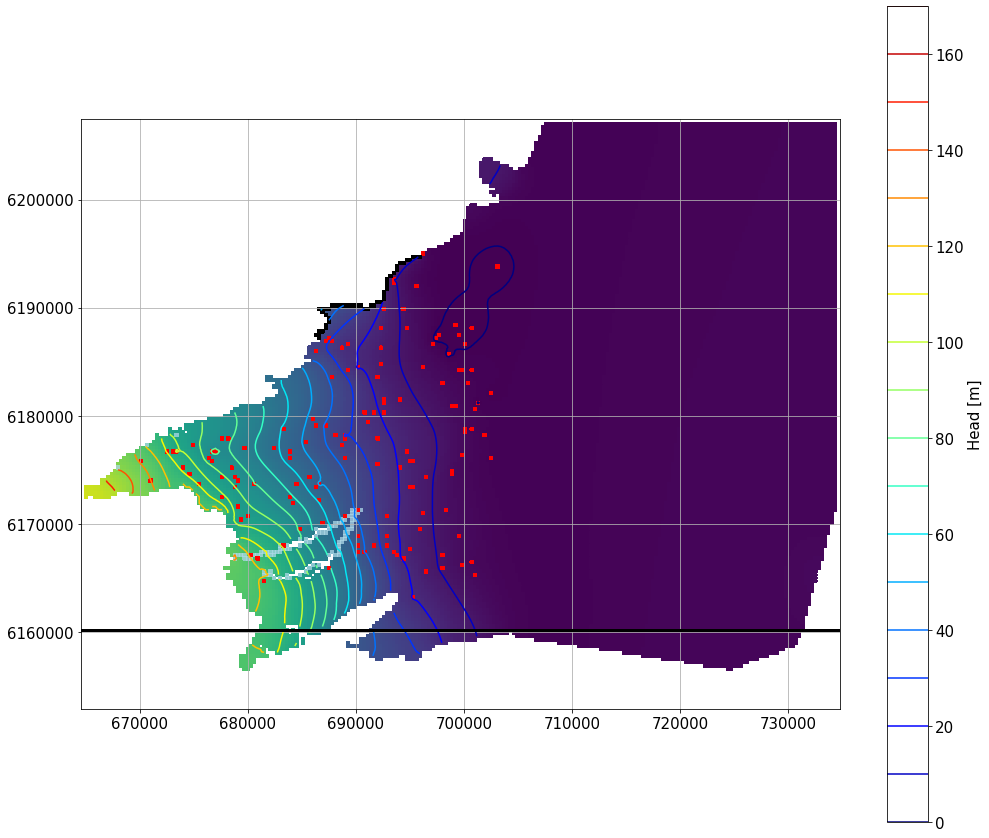

In [348]:
# retrieve heads and spdis 
head = get_heads(model_name,model_dir)
#spdis = get_spdis(model_name,model_dir)

# make a plot
fig = plt.figure(figsize=(17,15))
layer = 2
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf,layer=layer)

hmesh=ml.plot_array(head[layer],masked_values=[0,1e30],cmap="viridis")
hmesh.set_clim(0,170)
cont=ml.contour_array(head[layer],masked_values=[0,1e30],levels=np.linspace(0,170,18),cmap="jet")

# plot bc
ml.plot_bc("sea",color="b",alpha=0.5)

for riv in rivfiles:
    ml.plot_bc(riv,color="lightblue",alpha=0.5)

ml.plot_bc("eta",color="b",alpha=0.5)
ml.plot_bc("wel")
ml.plot_bc("Corb")
# plot Cross-section
row = 158
x = [x0,x1]
y = [y1-(row+.5)*delc,y1-(row+.5)*delc]
ax.plot(x,y,"k",linewidth=3)


ax.tick_params(labelsize=15)

g = plt.colorbar(cont)
g.set_label("Head [m]",fontsize=15)
g.ax.tick_params(labelsize=15)

ax.grid()

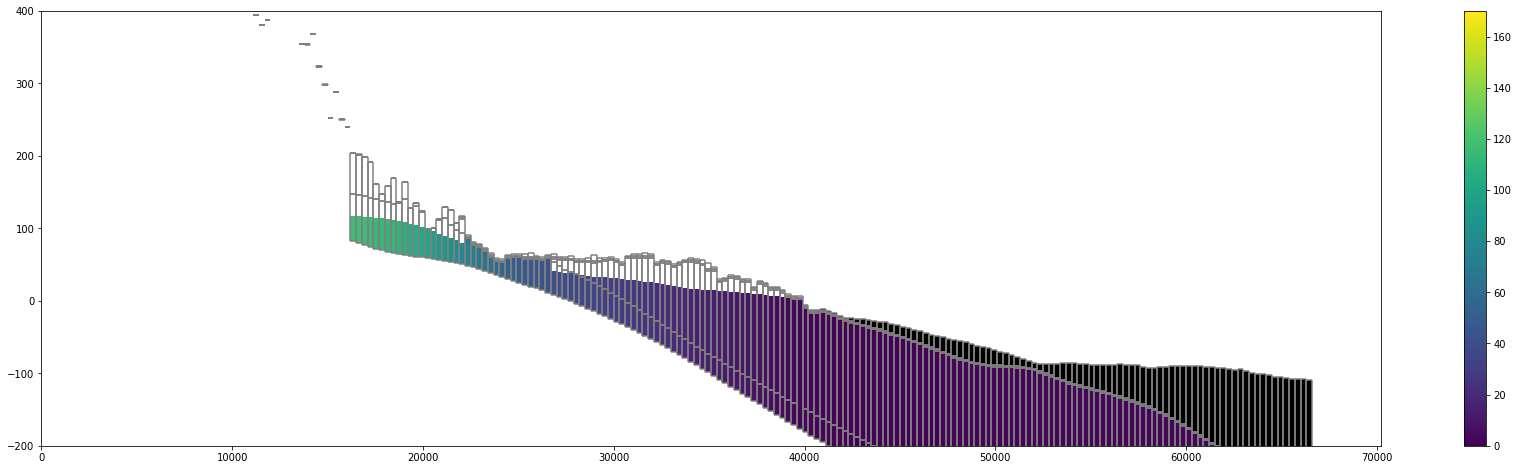

In [349]:
fig,ax = plt.subplots(figsize=(30,8))
x=fp.plot.PlotCrossSection(gwf,line={"row" :row})

arr=x.plot_array(head,masked_values=[1e30],head=head)
plt.colorbar(arr)
arr.set_clim(0,170)
x.plot_ibound()
x.plot_grid()
ax.set_ylim(-200,400)
x.plot_bc("sea")

TOTAL IN: 4.976094699999999 m3/s
TOTAL OUT: 4.9756965000000015 m3/s


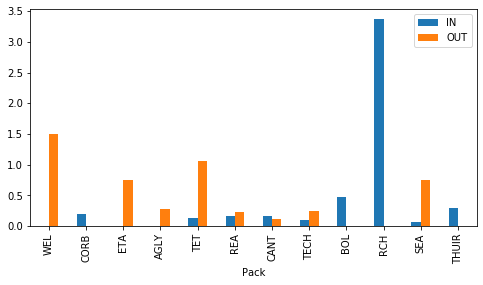

In [350]:
#total budget
fig,ax = plt.subplots(figsize=(8,4))
Budget = get_Total_Budget(model_name,model_dir)
Budget.set_index("Pack").plot(kind="bar",ax=ax)
print("TOTAL IN: {} m3/s".format(Budget.sum()["IN"]));
print("TOTAL OUT: {} m3/s".format(Budget.sum()["OUT"]));

Misfit : 4.238368031619663 m 


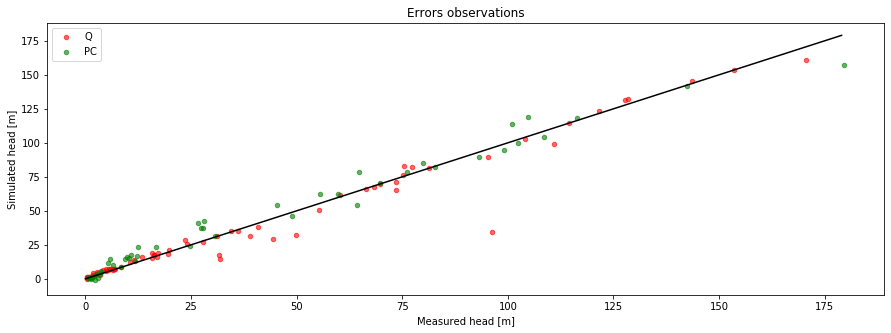

In [351]:
color = ["red","blue","green","black"]
label = ["Q","inter","PC","PMS"]
fig = plt.figure(figsize=(15,5))

for ilay in range(nlay):
    Control_pz = Control_Pz[ilay].reshape(nrow*ncol)
    head_c = head[ilay].reshape(nrow*ncol)
    
    head_c[head_c>1000]=None
    if (Control_pz!=0).any():
        plt.scatter(Control_pz[Control_pz!=0],head_c[Control_pz!=0],s=20,c=color[ilay],label=label[ilay],alpha=0.6)
plt.legend()
plt.plot(np.arange(180),np.arange(180),"k")
plt.xlabel("Measured head [m]")
plt.ylabel("Simulated head [m]")
plt.title("Errors observations")

Control_pz = Control_Pz.reshape(nlay*nrow*ncol)
head = head.reshape(nlay*nrow*ncol)
Misfit = np.abs((Control_pz[Control_pz!=0] - head[Control_pz!=0]))
print("Misfit : {} m ".format(np.nanmean(Misfit)))

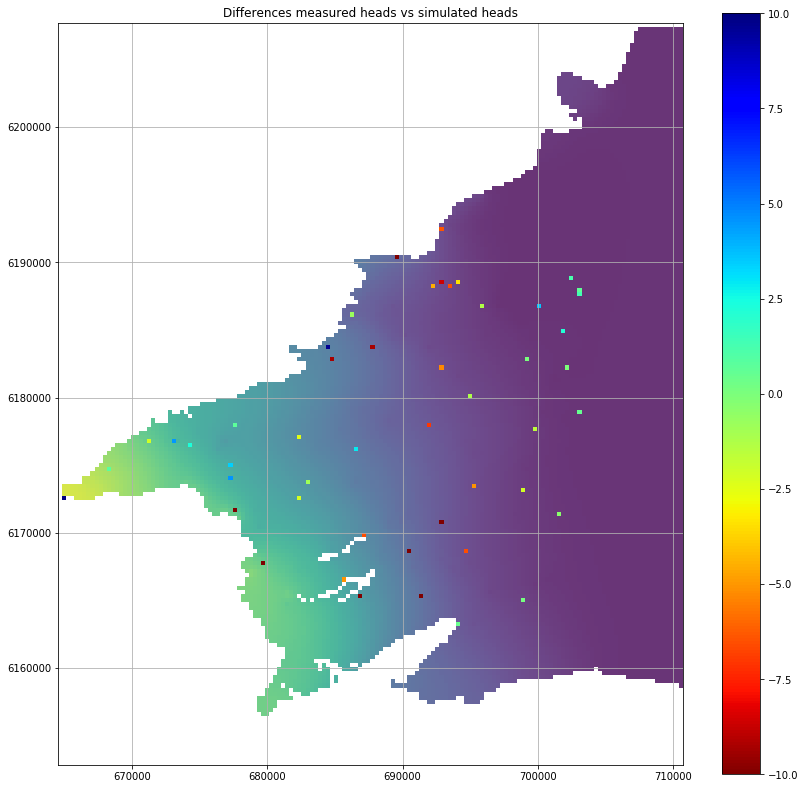

In [352]:
#errors map
layer = 2
head = get_heads(model_name,model_dir)
head[head>1000]=None
fig,ax=plt.subplots(figsize=(14,14))
back = plt.imshow(head[layer],extent=[x0,x1,y0,y1],alpha=0.8,cmap="viridis")
back.set_clim(0,170)
head = head.reshape(nlay*nrow*ncol)
head[Control_pz==0]=None
a=plt.imshow((Control_pz - head).reshape(nlay,nrow,ncol)[layer],extent=[x0,x1,y0,y1],cmap="jet_r")

plt.title("Differences measured heads vs simulated heads")
plt.xlim(x0,x1-2.4e4)
plt.colorbar()
plt.grid()
ecart = 10
a.set_clim(-ecart,ecart)

In [59]:
def Misfit(kh):
    
    fp.mf6.mfpackage.MFPackage(gwf,package_type="npf").remove()# remove pre-existing npf package
    
    K = np.ones([nlay,nrow,ncol])
    K[0] = kh[0]
    K[1] = 0.25e-8
    K[2] = kh[1]
    K[3] = kh[2]
    npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=K) # create the new npf package
    npf.write()
    
    if sim.run_simulation(silent = True): # And RUN !
        head = get_heads(model_name,model_dir)
        head[head>1000]=None
        head = head.reshape(nlay*nrow*ncol)
        
    return np.nanmean(np.abs((Control_pz[Control_pz!=0] - head[Control_pz!=0])))

In [52]:
#minimize(Misfit,[4e-4,3e-6,2e-4],method="Nelder-Mead")

In [405]:
a=[1,2,3]
b=[]

In [411]:
b.append(a)

In [413]:
pd.DataFrame(b).T

,0,1,2,3,4
0,1,1,1,1,1
1,2,2,2,2,2
2,3,3,3,3,3


### budget by zones (in progress...)

In [431]:
#poo tentative
class Zb():
    
    def __init__(self,zones,m_name,m_dir):
        
        # some attributes
        self.nlay = zones.shape[0]
        self.nrow = zones.shape[1]
        self.ncol = zones.shape[2]
        self.m_name = m_name
        self.m_dir = m_dir
        
        self.zones = zones
        
        nzones = np.unique(self.zones).shape[0]
        if 0 in np.unique(self.zones):
            nzones -=1
        self.nzones = nzones
        
        #retrieve cbc file
        self.cbc = get_cbc(m_name,m_dir)
        
        #IA and JA arrays
        fname = os.path.join(m_dir, '{}.dis.grb'.format(m_name))
        bgf = fp.utils.mfgrdfile.MfGrdFile(fname)
        self.ia = bgf._datadict['IA'] - 1
        self.ja = bgf._datadict['JA'] - 1
        
        ##df_pos
        self.df_pos = self._df_pos()
############################################################################################################        
## Methods
    
    def _df_pos(self):
        
        zones = self.zones
        ia = self.ia
        ja = self.ja
        
        def comb(m, lst):
            if m == 0: return [[]]
            return [[x] + suffix for i, x in enumerate(lst)
                    for suffix in comb(m - 1, lst[i + 1:])]
        
        seq=[]
        for zone in np.unique(zones):
            if zone != 0:
                seq.append(int(zone))
        lst_comb = comb(2, seq)

        zones = zones.reshape(self.nlay*self.nrow*self.ncol)
        lst_ipos=[]
        fromz2z=[]

        for zz in lst_comb:
            z1=zz[0]
            z2=zz[1]
            for celln in range(ia.shape[0]-1):
                if zones[celln] == z1:
                    for ipos in range(ia[celln]+1, ia[celln+1]): # loop for each connexions of celln
                        cellm = ja[ipos]  # retrieve cell number of adjacent cell
                        if (zones[cellm] == z2):
                            lst_ipos.append(ipos)
                            fromz2z.append("{}to{}".format(z1,z2))
        df_pos = pd.DataFrame({"ipos":lst_ipos,"dir":fromz2z})
        
        return df_pos
        
    def _flow_zz(self,kstpkper=None):
    
        """
        Return a matrix containing flux btw differents zones (each 2 columns correspond to one zone (1st is IN and 2nd OUT from the zone)
        each layer represent a zone (from zone 1 to zone n)
        cbc : cbc object
        df_pos : Dataframe with infos of connexions btw interzones cells (see get_dfpos)
        zones : the numpy 3D array with the zones
        kstpkper : array of size 2, indices that indicates stress period and time step
        """
        cbc = self.cbc
        zones = self.zones
        df_pos = self.df_pos
        nzones = self.nzones
        
        flowja = cbc.get_data(text='FLOW-JA-FACE',kstpkper=kstpkper)[0][0, 0, :]
        FluxZZ = np.zeros([nzones,2*nzones]) # interzones flows matrix

        for idir in df_pos.dir.unique():
            flow_pos=0
            flow_neg=0
            df_tmp = df_pos[df_pos.dir==idir]
            for ipos in df_tmp.ipos:
                if flowja[ipos]> 0:
                    flow_pos += flowja[ipos]
                else:
                    flow_neg -= flowja[ipos]

            FluxZZ[int(idir[-1])-1,(int(idir[0])*2-2):(int(idir[0])*2)] = (flow_pos,flow_neg)
            FluxZZ[int(idir[0])-1,(int(idir[-1])*2-2):(int(idir[-1])*2)] = (flow_neg,flow_pos)
        return FluxZZ
    
    
    def _flows_Pack2Z(self,pack,z1):

        """
        Calculate the flux from/to a modflow package to/from a given zone
        pack : the package budget data from the cbc file for example : cbc.get_data(text="chd")[0]
        z1 : the number of the zone that we want to investigate
        zones : the numpy 2D/3D array containing infos about zones (can't be 1D)
        return : IN/OUT flux (from/to) 
        """
        nlay = self.nlay
        nrow = self.nrow
        ncol = self.ncol
        zones = self.zones.reshape(nlay*nrow*ncol)
        flow_pos=0
        flow_neg=0
        for q1 in pack:
            if zones[q1[0]-1]==z1: # nodenumber is one based !

                if q1[2]>0:
                    flow_pos += q1[2]
                else:
                    flow_neg -= q1[2]

        return flow_pos,flow_neg

    def _flow_pack(self,kstpkper=None,n=1):
    
        """
        Return a df whith flux from/to zones/packages
        """

        cbc = self.cbc
        zones = self.zones
        
        DF_pack = pd.DataFrame()
        for z in np.unique(zones):
            if z != 0:
                pos=[]
                neg=[]
                pack_list=[]
                for i in range(pd.DataFrame(cbc.recordarray).shape[0]-n):
                    pack = cbc.get_data(i+n,kstpkper=None)[0]
                    posi,negi = self._flows_Pack2Z(pack,z)
                    pos.append(posi)
                    neg.append(negi)
                z_DF = pd.concat([pd.DataFrame(pos),pd.DataFrame(neg)],axis=1)
                DF_pack = pd.concat([DF_pack,z_DF],axis=1)

        return DF_pack
    
    def _index_pack(self,n=1):
        """
        return list of all packages name + zones
        """
        cbc = self.cbc
        zones = self.zones
        pack_list=[]

        for i in range(pd.DataFrame(cbc.recordarray).shape[0]-n):
            pack_list.append(str(cbc.recordarray[i+n][-1])[2:5])
        for zm in np.unique(zones):
            if zm != 0:
                pack_list.append("zone {}".format(int(zm)))

        return pack_list
    
    def get_Budget(self,kstpkper=None):
        
        cbc = self.cbc
        zones = self.zones
        df_pos = self.df_pos
        nzones = self.nzones
        
        FluxZZ = self._flow_zz(kstpkper=kstpkper)
        
        # total budgets for 1st stress period
        DF_pack = self._flow_pack(kstpkper=kstpkper,n=1)
        
        #append the two dataframes
        df_zz = pd.DataFrame(FluxZZ)
        col = np.zeros(nzones*2,dtype=int) # use same columns name because pd concat is stupid
        df_zz.columns=col

        DF_Budg = pd.concat([DF_pack,df_zz])# Union <3
        
        #index for the dataframe
        pack_list = self._index_pack(n=1)
        
        #create index, multicol, and have fun
        lst_z=[]
        for z in np.unique(zones):
            if z !=0:
                lst_z.append("zone {}".format(int(z)))
        columns = pd.MultiIndex.from_product([lst_z, ['FROM', 'TO']]) 
        index = pack_list
        DF_Budg = pd.DataFrame(DF_Budg.values,index=index,columns=columns)
        
        return DF_Budg

In [432]:
zb = Zb(zones,model_name,model_dir)

In [436]:
zb.get_Budget()

zone 1               zone 2              zone 3          
             FROM         TO      FROM        TO      FROM        TO
WEL      0.000000   0.498326  0.000000  0.498805  0.000000  0.508804
COR      0.000000   0.000000  0.200000  0.000000  0.000000  0.000000
ETA      0.000000   0.753751  0.000000  0.000000  0.000000  0.000000
AGL      0.004861   0.287058  0.000000  0.000000  0.000000  0.000000
TET      0.128722   1.050200  0.000000  0.013563  0.000000  0.000000
REA      0.089082   0.129176  0.084103  0.103661  0.000000  0.000000
CAN      0.000000   0.000000  0.162716  0.122067  0.000000  0.000000
TEC      0.099652   0.243368  0.000000  0.000000  0.000000  0.000000
BOL      0.481285   0.007797  0.000000  0.000000  0.000000  0.000000
RCH      2.358731   0.000000  0.982685  0.000000  0.028464  0.000000
SEA     19.641700  20.337749  0.000000  0.000000  0.000000  0.000000
THU      0.000000   0.000000  0.292794  0.000000  0.000000  0.000000
zone 1   0.000000   0.000000  0.426815  0.816390  0.013556  0.127358
zone 2   0.816390   0.426815  0.000000  0.000000  1.193489  0.598769
zone 3   0.127358   0.013556  0.598769  1.193489  0.000000  0.000000

In [378]:
cbc = get_cbc(model_name,model_dir)

fname = os.path.join(model_dir, '{}.dis.grb'.format(model_name))
bgf = fp.utils.mfgrdfile.MfGrdFile(fname)
ia = bgf._datadict['IA'] - 1
ja = bgf._datadict['JA'] - 1

In [379]:
#create the zones
a = np.array([1,1,2,3])
a = a[np.newaxis,np.newaxis,:]
zones = np.ones([nlay,nrow,ncol])*a.T
zones[idomain==0]=0

#remove some pack cells from zone 1 with ra_pack
#ra_pack(chd,zones,iper=0,value=0)

In [380]:
#number of zones
nzones = get_nzones(zones)

In [381]:
# get intercells interzones position
df_pos = get_dfpos(zones,ia,ja)

In [385]:
%%time
FluxZZ = flow_zz(cbc,df_pos,zones,kstpkper=(0,0))

# total budgets for 1st stress period
DF_pack = flow_pack(cbc,zones,1)

#append the two dataframes
df_zz = pd.DataFrame(FluxZZ)
col = np.zeros(nzones*2,dtype=int) # use same columns name because pd concat is stupid
df_zz.columns=col

DF_Budg = pd.concat([DF_pack,df_zz])# Union 

#index for the dataframe
pack_list = index_pack(cbc,zones,1)

Wall time: 113 ms


In [68]:
#create index, multicol, and have fun
lst_z=[]
for z in range(1,nzones+1):
    lst_z.append("zone {}".format(z))
columns = pd.MultiIndex.from_product([lst_z, ['FROM', 'TO']]) 
index = pack_list
DF_Budg = pd.DataFrame(DF_Budg.values,index=index,columns=columns)

In [69]:
# remove excedent budget from sea
mask = DF_Budg.loc["SEA"]!=0
DF_Budg.loc["SEA"][mask] = DF_Budg.loc["SEA"][mask]-DF_Budg.loc["SEA"][mask].min()

In [107]:
#plots

if os.path.exists('pictures'):
    shutil.rmtree('pictures')
os.makedirs("pictures")

z_list = DF_Budg.index[-nzones:]
I_O_list = ["TO","FROM"]


for z in z_list:
    for IN_OUT in I_O_list:
        fig,ax = plt.subplots(figsize=(9,6))
        labels = DF_Budg[DF_Budg[z][IN_OUT]!=0].index
        data = DF_Budg[z][IN_OUT][DF_Budg[z][IN_OUT]!=0].values
        data_pourc = DF_Budg[z][IN_OUT][DF_Budg[z][IN_OUT]!=0]/DF_Budg[z][IN_OUT][DF_Budg[z][IN_OUT]!=0].sum()
        
        wedges, texts,pct = ax.pie(data_pourc.values,pctdistance=0.8,
                                   wedgeprops=dict(width=0.5),autopct='%1.1f%%', startangle=0)

        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0)
        kw = dict(arrowprops=dict(arrowstyle="<-"),
                  bbox=bbox_props, zorder=0, va="center")
        xt = -5
        yt = -5
        ### arrows
        for i, p in enumerate(wedges):
            xta = xt
            yta = yt
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            xt = 1.3*np.sign(x)
            yt = 1.2*y
            if xt == xta:
                while((yta-yt)**2)< 0.01:
                    if yt >= yta:
                        yt += 0.001
                    else:
                        yt -= 0.001
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = "angle,angleA=0,angleB={}".format(ang)
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            annote = np.round(data[i],2)
            ax.annotate(annote, xy=(x, y), xytext=(xt,yt),
                        horizontalalignment=horizontalalignment, **kw)
        ###

        ax.set_title("{} : {}".format(z,IN_OUT))
        ax.set_position([0.1,0.1,0.5,0.7])
        ax.legend(wedges,labels,bbox_to_anchor=(1.5, 1))
        ax.text(-0.40,0,"TOTAL : {} m$^3/$s".format(np.round(data.sum(),3)))
        fig.savefig('pictures/{}_{}.png'.format(z,IN_OUT))
        plt.close()

In [421]:
DF_Budg.replace(0,"/")

,0,0,0,0,0,0
0,/,0.498326,/,0.498805,/,0.508804
1,/,/,0.2,/,/,/
2,/,0.753751,/,/,/,/
3,0.00486073,0.287058,/,/,/,/
4,0.128722,1.0502,/,0.0135628,/,/
5,0.0890822,0.129176,0.0841028,0.103661,/,/
6,/,/,0.162716,0.122067,/,/
7,0.0996521,0.243368,/,/,/,/
8,0.481285,0.00779653,/,/,/,/
9,2.35873,/,0.982685,/,0.0284641,/
